##### Train NER model with Bi-GRU

Dataset used is accessible at https://github.com/Text-Mining/Persian-NER

In [1]:
def read_ner_file(filepath):
    sentences = []
    sentence = []
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                parts = line.split("\t")
                if len(parts) == 2:
                    word, tag = parts
                    sentence.append((word, tag))
        if sentence:
            sentences.append(sentence)
    return sentences

In [2]:
root_data_Path = "NERDataset/"

raw_data_merged = []
for i in range(1, 6):
    dataPath = f"{root_data_Path}Persian-NER-part{i}.txt"
    print(f"Reading data from: {dataPath}")
    raw_data_merged.extend(read_ner_file(dataPath))

print(f"Total sentences read: {len(raw_data_merged)}")
for i, sentence in enumerate(raw_data_merged[:1]):  # Display first 5 sentences
    print(f"Sentence {i + 1}:")
    for word, tag in sentence:
        print(f"{word}\t{tag}")
    print()  # Newline for better readability

Reading data from: NERDataset/Persian-NER-part1.txt
Reading data from: NERDataset/Persian-NER-part2.txt
Reading data from: NERDataset/Persian-NER-part3.txt
Reading data from: NERDataset/Persian-NER-part4.txt
Reading data from: NERDataset/Persian-NER-part5.txt
Total sentences read: 976599
Sentence 1:
ویکی‌پدیای	O
انگلیسی	O
در	B-DAT
تاریخ	I-DAT
۱۵	I-DAT
ژانویه	I-DAT
۲۰۰۱	I-DAT
(	O
میلادی	B-DAT
)	O
۲۶	B-DAT
دی	I-DAT
۱۳۷۹	I-DAT
)	O
به	O
صورت	O
مکملی	O
برای	O
دانشنامه	O
تخصصی	O
نوپدیا	O
نوشته	O
شد	O
.	O



In [3]:
from collections import Counter

word_count = Counter()
tag_count = Counter()
tags = set()
for sentence in raw_data_merged:
    for word, tag in sentence:
        word_count[word] += 1
        tag_count[tag] += 1
        tags.add(tag)
print(f"Total unique words: {len(word_count)}")
print(f"Total unique tags: {len(tags)}")
print(f"Most common words: {word_count.most_common(10)}")

Total unique words: 355081
Total unique tags: 11
Most common words: [('در', 1059309), ('و', 1014935), ('.', 958501), ('به', 675717), ('،', 626591), ('از', 588984), ('که', 396644), ('را', 333945), ('این', 289082), ('سال', 247360)]


Total unique words: 355081
Min word count: 1
Max word count: 1059309
Mean word count: 70.47
Median word count: 1


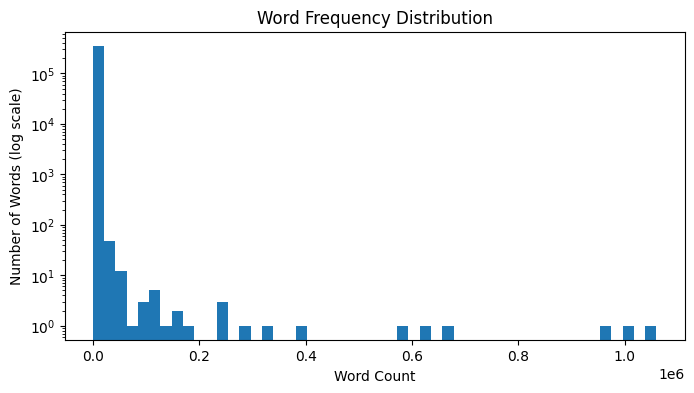

In [4]:
import matplotlib.pyplot as plt

# Show basic statistics
counts = list(word_count.values())
print(f"Total unique words: {len(counts)}")
print(f"Min word count: {min(counts)}")
print(f"Max word count: {max(counts)}")
print(f"Mean word count: {sum(counts) / len(counts):.2f}")
print(f"Median word count: {sorted(counts)[len(counts) // 2]}")

# Plot histogram of word frequencies (log scale for better visualization)
plt.figure(figsize=(8, 4))
plt.hist(counts, bins=50, log=True)
plt.title("Word Frequency Distribution")
plt.xlabel("Word Count")
plt.ylabel("Number of Words (log scale)")
plt.show()

Total unique tags: 11
Tag counts:
O: 20552420
B-DAT: 735264
I-DAT: 905806
B-PER: 386657
I-PER: 434585
B-ORG: 289998
I-ORG: 482481
B-LOC: 627845
I-LOC: 393379
B-EVE: 70845
I-EVE: 144579


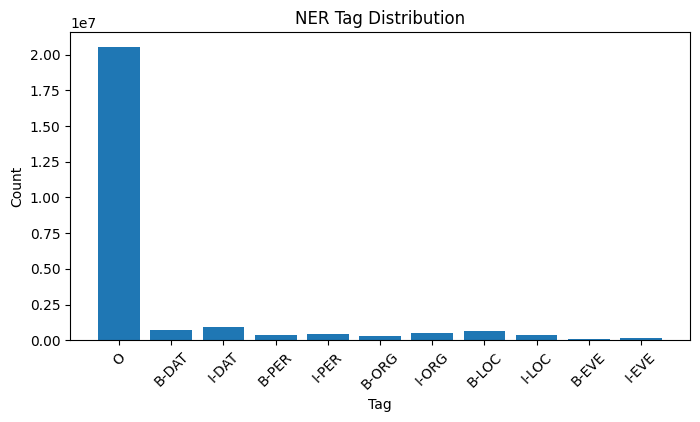

In [5]:
import matplotlib.pyplot as plt

# Show tag statistics
print(f"Total unique tags: {len(tags)}")
print("Tag counts:")
for tag, count in tag_count.items():
    print(f"{tag}: {count}")

# Plot tag distribution
plt.figure(figsize=(8, 4))
plt.bar(tag_count.keys(), tag_count.values())
plt.title("NER Tag Distribution")
plt.xlabel("Tag")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [8]:
vocabulary = set(word_count.keys())
print(f"Vocabulary size: {len(vocabulary)}")

Vocabulary size: 355081


In [9]:
UNKNOWN_TOKEN = "<UNK>"
PADDING_TOKEN = "<PAD>"
NON_ENTITY_TOKEN = "O"


def create_word_to_index(vocabulary):
    word_to_index = {word: idx + 2 for idx, word in enumerate(sorted(vocabulary))}
    word_to_index[UNKNOWN_TOKEN] = 0
    word_to_index[PADDING_TOKEN] = 1
    return word_to_index


def create_tag_to_index(labels):
    tag_to_index = {tag: idx + 1 for idx, tag in enumerate(sorted(labels))}
    tag_to_index[PADDING_TOKEN] = 0
    return tag_to_index


word2idx = create_word_to_index(vocabulary)
tag2idx = create_tag_to_index(tags)
idx2tag = {idx: tag for tag, idx in tag2idx.items()}
idx2word = {idx: word for word, idx in word2idx.items()}

In [10]:
import torch.nn as nn


class BiGRU_NER(nn.Module):
    def __init__(self, vocab_size, tagset_size, emb_dim=100, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.GRU(
            emb_dim, hidden_dim // 2, batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        logits = self.fc(x)
        return logits

In [11]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split
import torch


class NERDataset(Dataset):
    def __init__(self, sentences, word2idx, tag2idx):
        self.sentences = sentences
        self.word2idx = word2idx
        self.tag2idx = tag2idx

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        words, tags = zip(*sentence)
        word_indices = [
            self.word2idx.get(word, word2idx[UNKNOWN_TOKEN]) for word in words
        ]  # Use 0 for unknown words
        tag_indices = [
            self.tag2idx.get(tag, tag2idx[PADDING_TOKEN]) for tag in tags
        ]  # Use 0 for unknown tags
        return torch.tensor(word_indices, dtype=torch.long), torch.tensor(
            tag_indices, dtype=torch.long
        )


def collate_fn(batch):
    words, tags = zip(*batch)
    words_padded = pad_sequence(
        words, batch_first=True, padding_value=word2idx[PADDING_TOKEN]
    )  # 1 is the index for PADDING_TOKEN
    tags_padded = pad_sequence(
        tags, batch_first=True, padding_value=tag2idx[PADDING_TOKEN]
    )  # 0 is the index for PADDING_TOKEN
    return words_padded, tags_padded


batch_size = 16
train_split = int(0.9 * len(raw_data_merged))
full_dataset = NERDataset(raw_data_merged, word2idx, tag2idx)
train_dataset, val_dataset = random_split(
    full_dataset, [train_split, len(full_dataset) - train_split]
)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 878939
Validation dataset size: 97660


In [12]:
model = BiGRU_NER(len(word2idx), len(tag2idx), emb_dim=50, hidden_dim=128)
criterion = nn.CrossEntropyLoss(ignore_index=tag2idx[PADDING_TOKEN])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [13]:
from sklearn.metrics import balanced_accuracy_score
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)


def evaluate_model(model, val_loader):
    model.eval()
    all_targets = []
    all_preds = []
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=-1)

            mask = targets != tag2idx[PADDING_TOKEN]  # Ignore padding tokens
            all_targets.extend(targets[mask].cpu().numpy())
            all_preds.extend(predicted[mask].cpu().numpy())

    if all_targets:
        balanced_acc = balanced_accuracy_score(all_targets, all_preds)
    else:
        balanced_acc = 0
    print(f"Validation Balanced Accuracy: {balanced_acc:.4f}")


def train_model(
    model, train_loader, val_loader, criterion, optimizer, device="cpu", num_epochs=5
):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(
            f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}"
        )
        evaluate_model(model, val_loader)

Using device: cuda


In [14]:
train_model(
    model,
    train_loader,
    val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
)

Epoch 1/10, Loss: 0.2290
Validation Balanced Accuracy: 0.7450
Epoch 2/10, Loss: 0.1620
Validation Balanced Accuracy: 0.7626
Epoch 3/10, Loss: 0.1468
Validation Balanced Accuracy: 0.7699
Epoch 4/10, Loss: 0.1377
Validation Balanced Accuracy: 0.7838
Epoch 5/10, Loss: 0.1311
Validation Balanced Accuracy: 0.7943
Epoch 6/10, Loss: 0.1259
Validation Balanced Accuracy: 0.7998
Epoch 7/10, Loss: 0.1215
Validation Balanced Accuracy: 0.7898
Epoch 8/10, Loss: 0.1177
Validation Balanced Accuracy: 0.7980
Epoch 9/10, Loss: 0.1143
Validation Balanced Accuracy: 0.7972
Epoch 10/10, Loss: 0.1112
Validation Balanced Accuracy: 0.8000


In [17]:
example_sentence = "آقای محسن نامجو در تهران زندگی می‌کند."


def predict_ner(model, tokens, word2idx, tag2idx, device="cpu"):
    model.to(device)
    model.eval()

    token_ids = [word2idx.get(token, word2idx[UNKNOWN_TOKEN]) for token in tokens]
    input_tensor = torch.tensor(token_ids).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted_tags = torch.max(outputs, dim=-1)

    predicted_tags = predicted_tags.squeeze().cpu().numpy()
    idx_to_tag = {idx: tag for tag, idx in tag2idx.items()}
    return [(tokens[i], idx_to_tag[predicted_tags[i]]) for i in range(len(tokens))]

In [18]:
import os

model_half = model.half()
half_model_path = "biGRU_ner_half.pth"
torch.save(
    {"model_state_dict": model.state_dict(), "word2idx": word2idx, "tag2idx": tag2idx},
    half_model_path,
)

print(f"Model saved in half precision to {half_model_path}")
half_model_size = os.path.getsize(half_model_path)
print(f"Half precision model file size: {half_model_size} bytes")

Model saved in half precision to biGRU_ner_half.pth
Half precision model file size: 45939491 bytes


In [19]:
def load_half_model(model_path, device="cpu"):
    checkpoint = torch.load(model_path, map_location=device)
    model = BiGRU_NER(
        len(checkpoint["word2idx"]),
        len(checkpoint["tag2idx"]),
        emb_dim=50,
        hidden_dim=128,
    )
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    return model, checkpoint["word2idx"], checkpoint["tag2idx"]


model_loaded, word2idx_loaded, tag2idx_loaded = load_half_model(
    half_model_path, device=device
)

In [20]:
evaluate_model(model_loaded, val_loader)

Validation Balanced Accuracy: 0.8000


In [ ]:
from shekar import WordTokenizer

tokenizer = WordTokenizer()
test_ner_sentences = [
    "دکتر علی ربیعی در دانشگاه تهران تدریس می‌کند.",
    "خانم فاطمه معتمدآریا در فیلم سینمایی جدید بازی کرده است.",
    "آقای محمدرضا شجریان در ایران شناخته شده است.",
    "شرکت ایران خودرو در سال 1962 تأسیس شد.",
    "کتاب داستان‌های ایرانی توسط انتشارات امیرکبیر منتشر شده است.",
    "لیلا حاتمی در جشنواره کن حضور داشت.",
    "شرکت مایکروسافت در سیلیکون ولی دفتر دارد.",
    "ابوعلی سینا از مشاهیر بزرگ ایران است.",
    "فروشگاه رفاه در خیابان ولیعصر افتتاح شد.",
    "نمایشنامه مرگ فروشنده در تئاتر شهر به روی صحنه رفت.",
    "رئیس‌جمهور حسن روحانی به سازمان ملل سفر کرد.",
    "مسابقات فوتبال در ورزشگاه آزادی برگزار می‌شود.",
    "فیلم جدایی نادر از سیمین برنده جایزه اسکار شد.",
    "شرکت سامسونگ در کره جنوبی تأسیس شده است.",
    "بانک ملی ایران در سال ۱۳۰۷ آغاز به کار کرد.",
]


for sentence in test_ner_sentences:
    tokens = list(tokenizer.tokenize(sentence))
    predicted_entities = predict_ner(
        model_loaded, tokens, word2idx_loaded, tag2idx_loaded, device
    )
    print(f"Predicted entities for the sentence '{sentence}':")
    for word, tag in predicted_entities:
        print(f"{word}: {tag}")
    print()

Predicted entities for the sentence 'دکتر علی ربیعی در دانشگاه تهران تدریس می‌کند.':
دکتر: B-PER
علی: I-PER
ربیعی: I-PER
در: O
دانشگاه: B-LOC
تهران: I-LOC
تدریس: O
می‌کند: O
.: O

Predicted entities for the sentence 'خانم فاطمه معتمدآریا در فیلم سینمایی جدید بازی کرده است.':
خانم: B-PER
فاطمه: I-PER
معتمدآریا: I-PER
در: O
فیلم: O
سینمایی: O
جدید: O
بازی: O
کرده: O
است: O
.: O

Predicted entities for the sentence 'آقای محمدرضا شجریان در ایران شناخته شده است.':
آقای: B-PER
محمدرضا: I-PER
شجریان: I-PER
در: O
ایران: B-LOC
شناخته: O
شده: O
است: O
.: O

Predicted entities for the sentence 'شرکت ایران خودرو در سال 1962 تأسیس شد.':
شرکت: B-ORG
ایران: I-ORG
خودرو: I-ORG
در: B-DAT
سال: B-DAT
1962: I-DAT
تأسیس: O
شد: O
.: O

Predicted entities for the sentence 'کتاب داستان‌های ایرانی توسط انتشارات امیرکبیر منتشر شده است.':
کتاب: O
داستان‌های: O
ایرانی: O
توسط: O
انتشارات: B-ORG
امیرکبیر: I-ORG
منتشر: O
شده: O
است: O
.: O

Predicted entities for the sentence 'لیلا حاتمی در جشنواره کن حضور داشت.':
